In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import sklearn
import io
import random
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'



In [3]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]


df = pd.read_csv(train_url,header=None, names = col_names)

df_test = pd.read_csv(test_url, header=None, names = col_names)

print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [4]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


**Step 1: Data preprocessing:**

One-Hot-Encoding, tüm kategorik özellikleri ikili özelliklere dönüştürmek için kullanılır. One-Hot-Endcoding gereksinimi, bu transformatöre giriş, kategorik(ayrık) özelliklerle alınan değerleri ifade eden bir tam sayı matrisi olmalıdır. Çıktı, her bir sütunun olası bir değere karşılık geldiği seyrek bir matris olacaktır. Giriş özelliklerinin [0, n_values] aralığında değerler aldıkları varsayılmaktadır. Bu nedenle her kategoriyi bir sayıya dönüştürmek için özelliklerin öncelikle LabelEncoder ile dönüştürülmesi gerekir.

In [6]:
# sütunlar kategorik, henüz binary değil: protocol_type (column 2), service (column 3), flag (column 4).

print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [7]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


**LabelEncoder**

**Insert categorical features into a 2D numpy array**

In [8]:
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]

df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [9]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2


['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

**Transform categorical features into numbers using LabelEncoder()**

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)

print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())

# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


**One-Hot-Encoding**

In [11]:
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)


# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Test setteki eksik sütunlar eklenir**

In [12]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_red_i',
 'service_harvest',
 'service_urh_i',
 'service_aol',
 'service_http_8001',
 'service_http_2784']

In [13]:
for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)
print(testdf_cat_data.shape)

(125973, 84)
(22544, 84)


**Ana dataframe'e yeni sayısal sütunlar eklenir**

In [14]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


 Dataset her atak kategorisi için ayrı datasetlere ayrıldı. Atak etiketleri her biri için yeniden adlandırıldı. 0=Normal, 1=DoS, 2=Probe, 3=R2L, 4=U2R. Yeni datasetlerde etiket sütunu yeni değerler ile değiştirildi.

 DoS :

 Probe :

 R2L :

 U2R :

In [15]:
labeldf=newdf['label']
labeldf_test=newdf_test['label']


# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

In [16]:
to_drop_DoS = [0,1]
to_drop_Probe = [0,2]
to_drop_R2L = [0,3]
to_drop_U2R = [0,4]

# Kendisi dışındaki label değerine sahip tüm satırları filtrele
# isin filter function

DoS_df=newdf[newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[newdf['label'].isin(to_drop_U2R)];



#test
DoS_df_test=newdf_test[newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[newdf_test['label'].isin(to_drop_U2R)];


print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print()
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)

Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


**Step 2: Feature Scaling**

In [17]:
# Split dataframes into X & Y
# X Özellikler , Y sonuç değişkenleri

X_DoS = DoS_df.drop('label',axis=1)
Y_DoS = DoS_df.label

X_Probe = Probe_df.drop('label',axis=1)
Y_Probe = Probe_df.label

X_R2L = R2L_df.drop('label',axis=1)
Y_R2L = R2L_df.label

X_U2R = U2R_df.drop('label',axis=1)
Y_U2R = U2R_df.label

# test set
X_DoS_test = DoS_df_test.drop('label',axis=1)
Y_DoS_test = DoS_df_test.label

X_Probe_test = Probe_df_test.drop('label',axis=1)
Y_Probe_test = Probe_df_test.label

X_R2L_test = R2L_df_test.drop('label',axis=1)
Y_R2L_test = R2L_df_test.label

X_U2R_test = U2R_df_test.drop('label',axis=1)
Y_U2R_test = U2R_df_test.label


# Feature Selection by Chi Square Test

**Chi Square Test:**

In [18]:
from sklearn.feature_selection import chi2, SelectKBest

def find_best_feature(x,y):
    chi2_selector = SelectKBest(score_func=chi2)
    chi2_selector.fit(x,y)
    score = pd.Series(chi2_selector.scores_)
    score.index = x.columns
    return score

<Axes: >

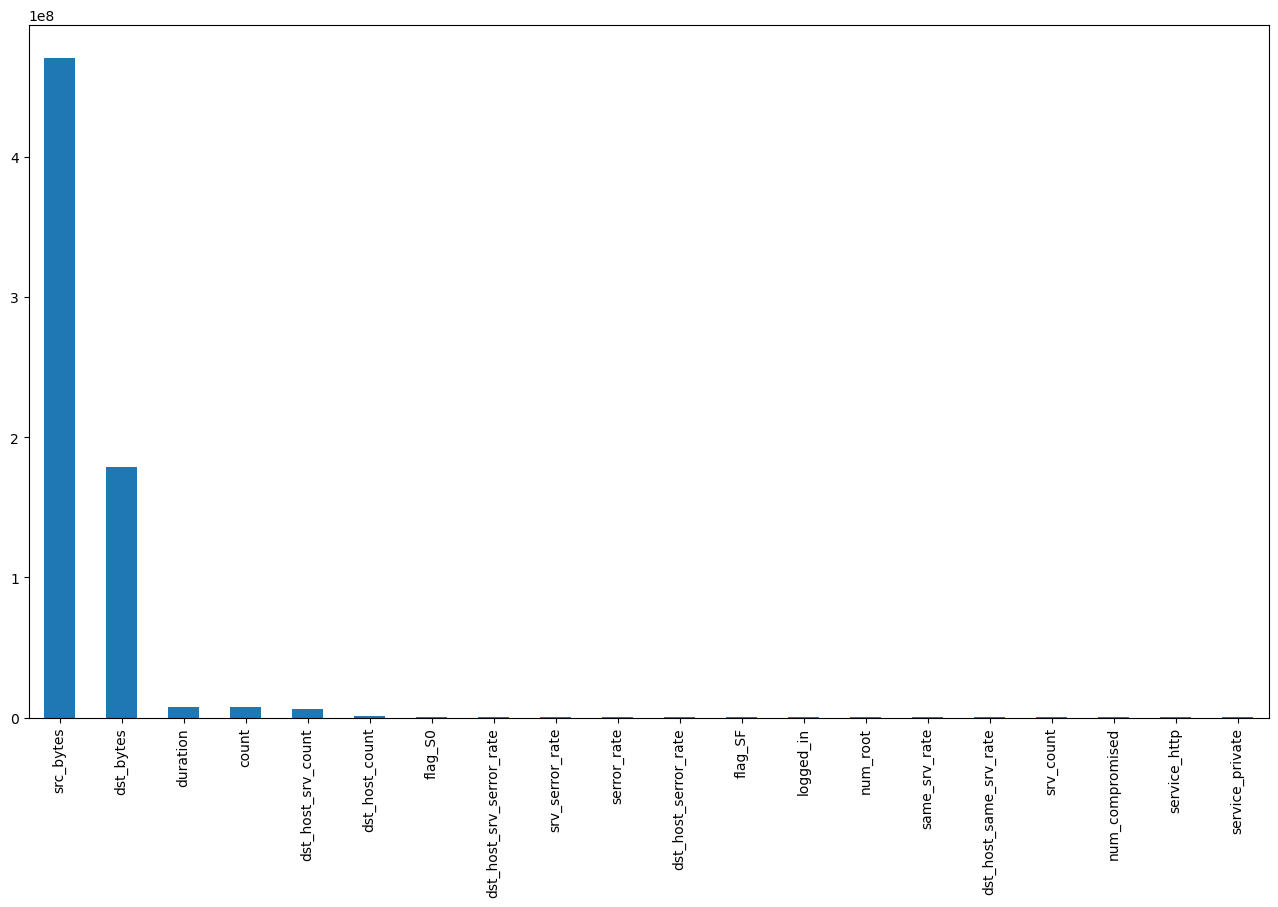

In [19]:
import matplotlib.pyplot as plt

dos_bf = find_best_feature(X_DoS,Y_DoS)
plt.figure(figsize=(16,9))
dos_bf.nlargest(20).plot(kind='bar')

In [20]:
dos_bf = dos_bf.nlargest(20)

X_DoS = X_DoS[dos_bf.index]
X_DoS_test = X_DoS_test[dos_bf.index]

In [21]:
dos_bf.index.shape

(20,)

<Axes: >

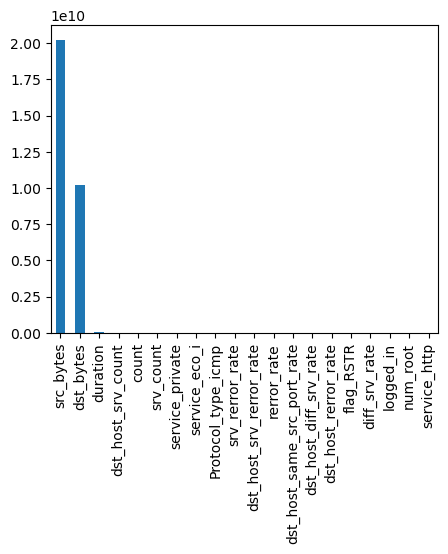

In [22]:
# checking for Probe
probe_bf = find_best_feature(X_Probe,Y_Probe)
plt.figure(figsize=(5,4))
probe_bf.nlargest(20).plot(kind='bar')

In [23]:
probe_bf = probe_bf.nlargest(10)

X_Probe = X_Probe[probe_bf.index]
X_Probe_test = X_Probe_test[probe_bf.index]

<Axes: >

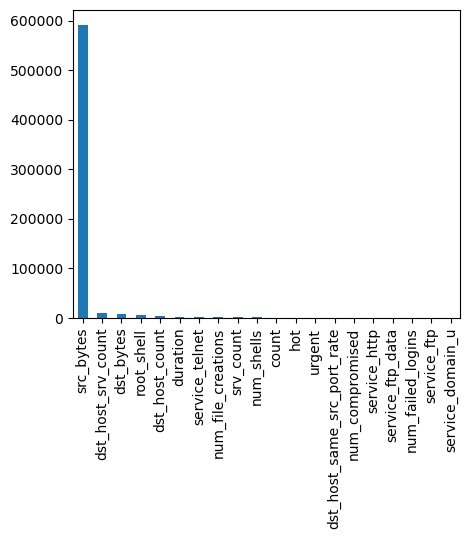

In [24]:
# checking for U2R
u2r_bf = find_best_feature(X_U2R,Y_U2R)
plt.figure(figsize=(5,4))
u2r_bf.nlargest(20).plot(kind='bar')

In [25]:
u2r_bf = u2r_bf.nlargest(11)

X_U2R = X_U2R[u2r_bf.index]
X_U2R_test = X_U2R_test[u2r_bf.index]

<Axes: >

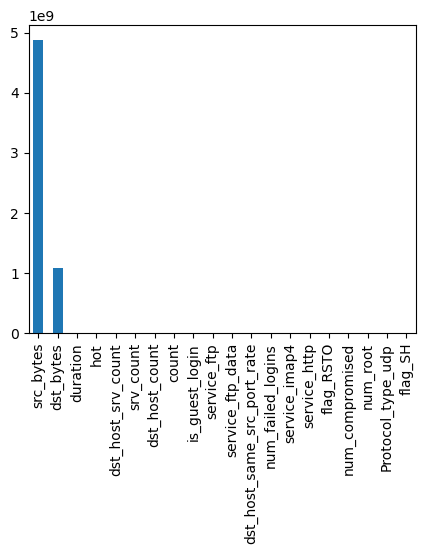

In [26]:
# checking for R2L
r2l_bf = find_best_feature(X_R2L,Y_R2L)
plt.figure(figsize=(5,4))
r2l_bf.nlargest(20).plot(kind='bar')

In [27]:
r2l_bf = r2l_bf.nlargest(10)

X_R2L = X_R2L[r2l_bf.index]
X_R2L_test = X_R2L_test[r2l_bf.index]

In [28]:
from sklearn.preprocessing import MinMaxScaler

def scale(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df

In [29]:
# train data
X_DoS = scale(X_DoS)
X_Probe = scale(X_Probe)
X_R2L = scale(X_R2L)
X_U2R = scale(X_U2R)

# test data
X_DoS_test = scale(X_DoS_test)
X_Probe_test = scale(X_Probe_test)
X_R2L_test = scale(X_R2L_test)
X_U2R_test = scale(X_U2R_test)

# Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
print(X_DoS.shape)
print(X_Probe.shape)
print(X_R2L.shape)
print(X_U2R.shape)


(113270, 20)
(78999, 10)
(68338, 10)
(67395, 11)


**Step 4: Build the model:**

Classifier is trained for all features and for reduced features, for later comparison.

The classifier model itself is stored in the clf variable.

In [32]:
# selected features
clf_rfeDoS=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_rfeProbe=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_rfeR2L=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_rfeU2R=RandomForestClassifier(n_estimators=10,n_jobs=2)

clf_rfeDoS.fit(X_DoS, Y_DoS.astype(int))
clf_rfeProbe.fit(X_Probe, Y_Probe.astype(int))
clf_rfeR2L.fit(X_R2L, Y_R2L.astype(int))
clf_rfeU2R.fit(X_U2R, Y_U2R.astype(int))

RandomForestClassifier(n_estimators=10, n_jobs=2)

**Step 5: Prediction & Evaluation (validation):**


---



Using all Features for each category

Confusion Matrices


---



DoS¶

**Probe**

In [33]:
Y_DoS_pred = clf_rfeDoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9536,175
1,1890,5570


**Probe**

In [34]:
Y_Probe_pred = clf_rfeProbe.predict(X_Probe_test)

# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,2
Actual attacks,,
0,9007,704
2,1142,1279


**R2L**

In [35]:
Y_R2L_pred = clf_rfeR2L.predict(X_R2L_test)

# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,3
Actual attacks,,
0,9708,3
3,2711,174


**U2R**

In [36]:
Y_U2R_pred = clf_rfeU2R.predict(X_U2R_test)

# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9710,1
4,59,8


**Cross Validation: Accuracy, Precision, Recall, F-measure**

**DoS**


In [38]:
from sklearn.model_selection import cross_val_score

In [39]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeDoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeDoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeDoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99802 (+/- 0.00300)
Precision: 0.99852 (+/- 0.00223)
Recall: 0.99625 (+/- 0.00394)
F-measure: 0.99752 (+/- 0.00339)


**Probe**

In [41]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeProbe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeProbe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeProbe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))


Accuracy: 0.99505 (+/- 0.00304)
Precision: 0.99395 (+/- 0.00569)
Recall: 0.98952 (+/- 0.00888)
F-measure: 0.99236 (+/- 0.00521)


**R2L**

In [43]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeR2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeR2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeR2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97594 (+/- 0.00876)
Precision: 0.96995 (+/- 0.00979)
Recall: 0.96284 (+/- 0.01308)
F-measure: 0.96565 (+/- 0.00963)


**U2R**

In [44]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeU2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeU2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeU2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99755 (+/- 0.00332)
Precision: 0.96370 (+/- 0.11049)
Recall: 0.83773 (+/- 0.18480)
F-measure: 0.87441 (+/- 0.08748)


# KNeighbors


In [45]:
from sklearn.neighbors import KNeighborsClassifier

clf_KNN_DoS=KNeighborsClassifier()
clf_KNN_Probe=KNeighborsClassifier()
clf_KNN_R2L=KNeighborsClassifier()
clf_KNN_U2R=KNeighborsClassifier()

clf_KNN_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_KNN_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_KNN_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_KNN_U2R.fit(X_U2R, Y_U2R.astype(int))


KNeighborsClassifier()

 **DoS**

In [46]:
Y_DoS_pred=clf_KNN_DoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9171,540
1,2080,5380


**Probe**

In [47]:
Y_Probe_pred=clf_KNN_Probe.predict(X_Probe_test)
# Create confusion matrix

pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9268,443
2,1066,1355


**R2L**

In [48]:
Y_R2L_pred=clf_KNN_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9696,15
3,2562,323


**U2R**

In [49]:
Y_U2R_pred=clf_KNN_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9708,3
4,56,11


**Cross Validation: Accuracy, Precision, Recall, F-measure**

**DoS**

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_KNN_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_KNN_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_KNN_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_KNN_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97653 (+/- 0.00652)
Precision: 0.96955 (+/- 0.01011)
Recall: 0.97668 (+/- 0.00849)
F-measure: 0.97309 (+/- 0.00746)


**Probe**

In [51]:
accuracy = cross_val_score(clf_KNN_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_KNN_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_KNN_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_KNN_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97906 (+/- 0.00635)
Precision: 0.96679 (+/- 0.00920)
Recall: 0.96786 (+/- 0.01615)
F-measure: 0.96725 (+/- 0.01019)


**R2L**

In [52]:
accuracy = cross_val_score(clf_KNN_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_KNN_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_KNN_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_KNN_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.92767 (+/- 0.00956)
Precision: 0.88800 (+/- 0.01094)
Recall: 0.91788 (+/- 0.02108)
F-measure: 0.90145 (+/- 0.01424)


**U2R**

In [53]:
accuracy = cross_val_score(clf_KNN_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_KNN_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_KNN_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_KNN_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))


Accuracy: 0.99519 (+/- 0.00225)
Precision: 0.86907 (+/- 0.15357)
Recall: 0.75875 (+/- 0.12447)
F-measure: 0.79463 (+/- 0.09096)


# SVM


In [54]:
from sklearn.svm import SVC

clf_SVM_DoS=SVC(kernel='linear', C=1.0, random_state=0)
clf_SVM_Probe=SVC(kernel='linear', C=1.0, random_state=0)
clf_SVM_R2L=SVC(kernel='linear', C=1.0, random_state=0)
clf_SVM_U2R=SVC(kernel='linear', C=1.0, random_state=0)

clf_SVM_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_SVM_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_SVM_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_SVM_U2R.fit(X_U2R, Y_U2R.astype(int))

SVC(kernel='linear', random_state=0)

**DoS**

In [55]:
Y_DoS_pred=clf_SVM_DoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9062,649
1,2332,5128


In [56]:
Y_Probe_pred=clf_SVM_Probe.predict(X_Probe_test)
# Create confusion matrix

pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9039,672
2,931,1490


In [57]:
Y_R2L_pred=clf_SVM_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
3,2885


In [58]:
Y_U2R_pred=clf_SVM_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
4,67


**DoS**

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_SVM_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_SVM_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_SVM_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_SVM_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.93582 (+/- 0.01008)
Precision: 0.96849 (+/- 0.01169)
Recall: 0.88097 (+/- 0.01980)
F-measure: 0.92262 (+/- 0.01267)


**Probe**

In [60]:
accuracy = cross_val_score(clf_SVM_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_SVM_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_SVM_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_SVM_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.95376 (+/- 0.00673)
Precision: 0.94314 (+/- 0.01107)
Recall: 0.90910 (+/- 0.01716)
F-measure: 0.92476 (+/- 0.01161)


**R2L**

In [61]:
accuracy = cross_val_score(clf_SVM_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_SVM_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_SVM_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_SVM_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.81510 (+/- 0.01008)
Precision: 0.86842 (+/- 0.03404)
Recall: 0.60209 (+/- 0.01983)
F-measure: 0.61662 (+/- 0.02901)


**U2R**

In [62]:
accuracy = cross_val_score(clf_SVM_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_SVM_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_SVM_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_SVM_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99499 (+/- 0.00250)
Precision: 0.89878 (+/- 0.20987)
Recall: 0.70073 (+/- 0.08810)
F-measure: 0.76035 (+/- 0.09882)
